In [1]:
import matplotlib.pyplot as plt
import numpy as np
import diagnostics as diag
import numpy.ma as ma

In [2]:
exp = diag.plume('../../data/Nyles/forced_plume_32z/', 'forced_plume_32z')

In [3]:
M_flux_lvl = exp.Flux_levels('momentum', r_lim=0.3)

In [4]:
M_flux_lvl.shape

(145, 32)

In [5]:
z = exp.read_vars('z')['z']

In [6]:
plume_height = np.zeros(145)
for t in range(145):
    idx = diag.find_z_plume(M_flux_lvl[t], 0.1)
    plume_height[t] = z[idx]

In [7]:
variables = exp.read_vars(['x', 'y', 'z', 'w'])

x = variables['x']
y = variables['y']
z = variables['z']

XZ, ZX = np.meshgrid(x/exp.params['Lx']-0.5, z/exp.params['Lz'])
XY, YX = np.meshgrid(x/exp.params['Lx']-0.5, y/exp.params['Ly'])

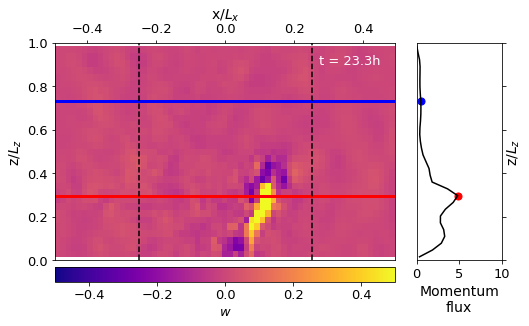

In [8]:
n = 140
maxx = 0.5
minn = -0.5
Lz = 2000

field = variables['w']#/62.5
z_plume_idx = diag.find_z_plume(M_flux_lvl[n], 0.1)
M_max_idx = diag.find_z_plume(M_flux_lvl[n], 1) 

plt.rcParams.update({'font.size': 13})
fig, (ax1, ax2) = plt.subplots(ncols=2, 
                             gridspec_kw = {'width_ratios':[4, 1], 'wspace': 0.1}, 
                             sharey=True)
fig.set_size_inches(8,4)

im1 = ax1.pcolormesh(XZ, ZX, field[n, :, 32, :], cmap='plasma',
                    vmin=minn, vmax=maxx)
ax1.axhline(z[z_plume_idx]/Lz, c='blue', lw=3)
ax1.axhline(z[M_max_idx]/Lz, c='red', lw=3)
ax1.axvline(0.25, c='k', linestyle='--')
ax1.axvline(-0.25, c='k', linestyle='--')
ax1.set_xlabel('x/$L_x$', fontsize=14)
ax1.set_ylabel('z/$L_z$', fontsize=14)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.text(0.27, 0.9, f't = {exp.time[n]/3600:0.1f}h', color='w')

ax2.plot(M_flux_lvl[n], z/Lz, c='k')
ax2.scatter(M_flux_lvl[n, z_plume_idx], z[z_plume_idx]/Lz, c='blue', s=50)
ax2.scatter(M_flux_lvl[n, M_max_idx], z[M_max_idx]/Lz, c='red', s=50)
ax2.yaxis.tick_right()
ax2.set_ylim(0,1)
ax2.set_xlim(0,10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel('Momentum\nflux', fontsize=14) #'$\mathscr{P}$'
ax2.set_ylabel('z/$L_z$', fontsize=14)

p0 = ax1.get_position().get_points().flatten()
p2 = ax2.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.05, p0[2] - p0[0], 0.05])
cbar = plt.colorbar(im1, cax=ax_cbar, orientation='horizontal')
cbar.set_label('$w$')

In [9]:
(plume_height/2000).mean()

0.5539870689655172

Text(0.5, 0, 'time (hours)')

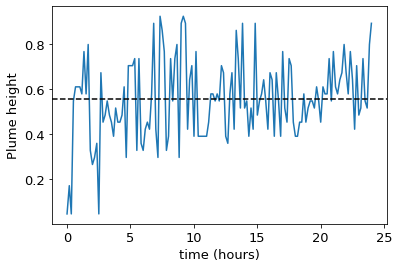

In [10]:
z_mean = (plume_height/2000).mean()
plt.plot(exp.time/3600, plume_height/2000)
plt.axhline(y=z_mean, color='k', ls='--')
plt.ylabel('Plume height')
plt.xlabel('time (hours)')

Text(0.5, 0, 'time (hours)')

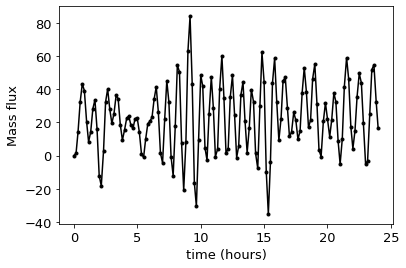

In [11]:
mass_flux = exp.Flux('mass', 0.3, z_mean)
plt.plot(exp.time/3600, mass_flux, 'k.-')
plt.ylabel('Mass flux')
plt.xlabel('time (hours)')

Text(0.5, 0, 'time (hours)')

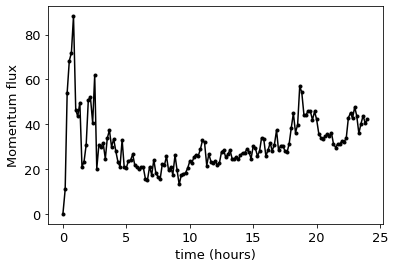

In [12]:
momentum_flux = exp.Flux('momentum', 0.2, z_mean)
plt.plot(exp.time/3600, momentum_flux, 'k.-')
plt.ylabel('Momentum flux')
plt.xlabel('time (hours)')

Text(0.5, 0, 'time (hours)')

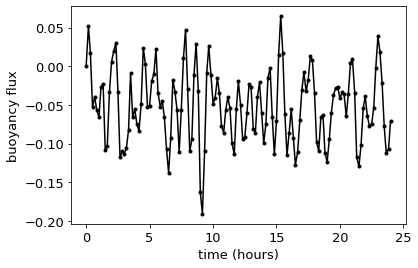

In [13]:
buoyancy_flux = exp.Flux('buoyancy', 0.3, z_mean)
plt.plot(exp.time/3600, buoyancy_flux, 'k.-')
plt.ylabel('buoyancy flux')
plt.xlabel('time (hours)')

# computing heat budget

In [14]:
x = exp.read_vars(['x'])['x']
y = exp.read_vars(['y'])['y']

In [15]:
X, Y = np.meshgrid(x/exp.params['Lx'] - 0.5,
                             y/exp.params['Ly'] - 0.5)
r = np.sqrt(X**2 + Y**2)

In [17]:
u = diag.velocity_interpolation(exp.read_vars('u')['u'], axis=3)
v = diag.velocity_interpolation(exp.read_vars('v')['v'], axis=2)
b = exp.read_vars('b')['b']

In [18]:
proy = (u[100, 8]*X + v[100, 8]*Y)/r

In [19]:
lateral = proy*b[100, 8]

In [21]:
mask = ma.masked_outside(r, 0, 0.25)
m = mask.mask*1
mask_lap = np.roll(m, -1, axis=0) + np.roll(m, 1, axis=0)
mask_lap += np.roll(m, -1, axis=1) + np.roll(m, 1, axis=1)
mask_lap -= 4*m

lat_ring = ma.masked_array(lateral, mask_lap>=0)

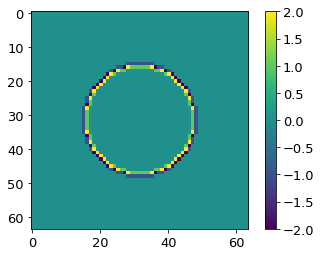

In [22]:
plt.imshow(mask_lap)
plt.colorbar()

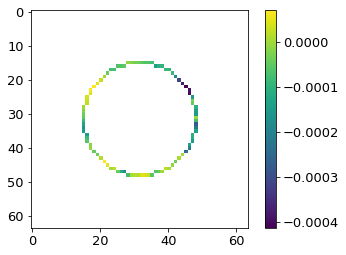

In [23]:
plt.imshow(lat_ring)
plt.colorbar()

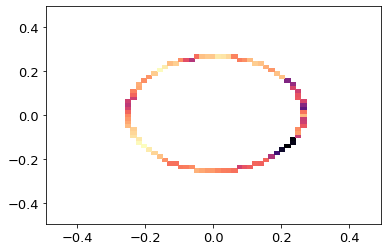

In [24]:
# plt.figure(figsize=(15,4))
# plt.subplot(131)
# plt.pcolormesh(X,Y, u[100, 8])
# plt.colorbar()
# plt.subplot(132)
# plt.pcolormesh(X,Y, v[100, 8])
# plt.colorbar()
plt.subplot()
#plt.pcolormesh(X,Y, proy)
#ring = ma.masked_array(proy, mask.mask)
plt.pcolormesh(X, Y, lat_ring, cmap='magma')
#plt.colorbar()

In [33]:
b_budget = exp.Budget('b', 0.25, 0.55)

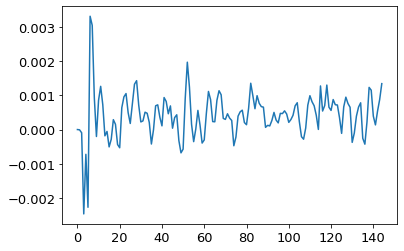

In [34]:
plt.plot(b_budget)

In [27]:
KE_budget = exp.Budget('KE', 0.25, 0.55)

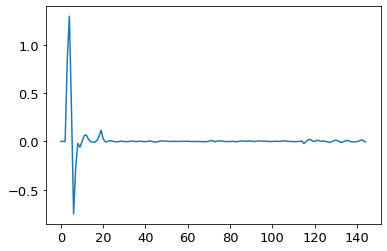

In [28]:
plt.plot(KE_budget)